# Preprocessing zu 'Titanic - who will survive?'

Multivariate Analysemethoden (SoSe 2022)

Gruppe 4: Florian Landmann, Florian Obermeier, Kristin Schwarzmueller

---

Datenquelle: https://www.kaggle.com/competitions/titanic/data


In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcol

# 0.Daten mounten und laden
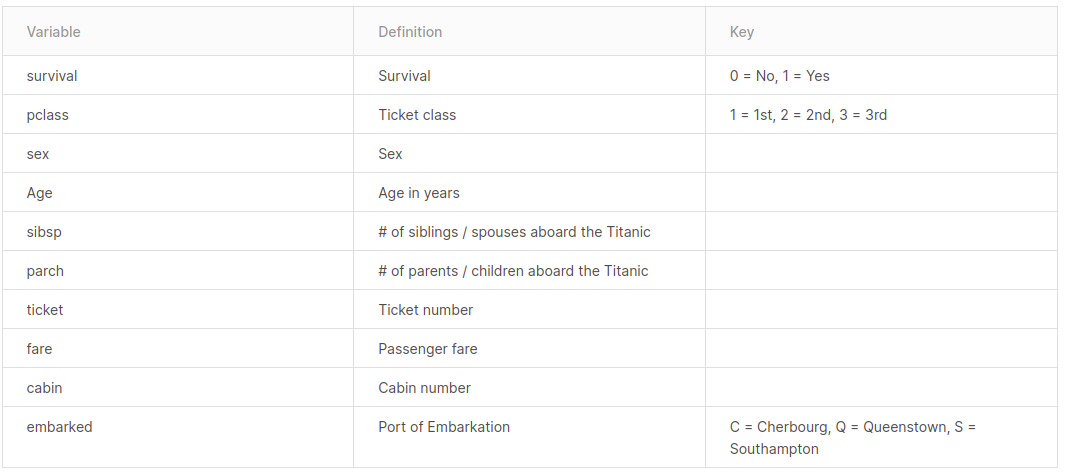

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/MVA/' # todo für Flos: den Ordner möglichst so verschieben, dass er im Gleichen Pfad im eurem Drive liegt
train_raw = pd.read_csv (path + 'train.csv')
test_raw = pd.read_csv (path + 'test.csv')

train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
print("Nan values in Age: {}".format(train_raw['Age'].isnull().sum()))
print("Nan values in Cabin: {}".format(train_raw['Cabin'].isnull().sum()))
print("Nan values in Embarked: {}".format(train_raw['Embarked'].isnull().sum()))
print("Nan values in Survived: {}".format(train_raw['Survived'].isnull().sum()))
print("Nan values in Fare: {}".format(train_raw['Fare'].isnull().sum()))

Nan values in Age: 177
Nan values in Cabin: 687
Nan values in Embarked: 2
Nan values in Survived: 0
Nan values in Fare: 0


In [ ]:
# def extract_wife_name(name):
#   if name.find('(') != -1:
#     name = name.split('(')[1].split(')')[0]
#   return name
# 
# def del_nickname(name):
#   if name.find('("') != -1:
#     name = name.split('("')[0].split('")')[0]
#   elif name.find(' "') != -1:
#     name = name.split('"')[0].split(')')[0]
#   return name

def preproces(data):
      
  # add length of name 
  if 'Name' in data.columns:
    # data['Name'] = data['Name'].apply(lambda x: del_nickname(x))
    # data['Name'] = data['Name'].apply(lambda x: extract_wife_name(x))
    data['Name len'] = data['Name'].apply(lambda x: len(x))

  # one hot encoding of gender to female
  if 'Sex' in data.columns:
    dummy = pd.get_dummies(data['Sex'])
    data['Female'] = dummy['female']
    data = data.drop(columns=['Sex'])

  # fill nan's in Age with avg age of class and gender
  if 'Age' in data.columns:
    data['Age known Flag'] = data['Age'].apply(lambda x: 0 if pd.isnull(x) else 1)
    d = data.groupby(['Female', 'Pclass'])['Age']
    data['Age'] = d.transform(lambda x: x.fillna(x.mean()))
  
  # concentrate family size as it is not very important
  if 'SibSp' in data.columns and 'Parch' in data.columns:
    data['Fam_Size'] = np.where((data['SibSp']+data['Parch']) == 0 , 0, # single 
                    np.where((data['SibSp']+data['Parch']) <= 3,     1, # some 
                                                                     2)) # big family 

  # embarked
  if 'Embarked' in data.columns:
    dummy = pd.get_dummies(data['Embarked'])
    data['Cherbourg'] = dummy['C']
    data['Queenstown'] = dummy['Q']
    data['Southhampton'] = dummy['S']

  # embarked as integer
  if 'Embarked' in data.columns:
    data['Embarked number'] = np.where((data['Embarked']) == 'S', 1,
                              np.where((data['Embarked']) == 'C', 2,
                              np.where((data['Embarked']) == 'Q', 3,
                                                                  0)))
  # cabin
  if 'Cabin' in data.columns:
    data['Cabine known Flag'] = data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1) 
    data['Numbert of Cabins'] = 1
    data['Cabin letter'] = "NaN"
    data['Cabin number'] = float("NaN")
    for i in range(len(data)):
      a = data.at[i,'Cabin']
      
      if pd.isnull(a):
        continue        
      
      a = a.split(" ")
      letter = a[0][0]
      number = a[0][1:]
      data.at[i,'Numbert of Cabins'] = len(a)
      data.at[i,'Cabin letter'] = a[0][0]
      try:
          data.at[i,'Cabin number'] = float(a[0][1:]) #some just have "F" w/o number
      except:
          pass
    
    data = data.drop(columns=['Cabin'])   

    dummy = pd.get_dummies(data['Cabin letter'])
    data = pd.concat([data, dummy], axis=1)  
    
  return data

train = preproces(train_raw)
test = preproces(test_raw)
train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin number,A,B,C,D,E,F,G,NaN,T
0,1,0,3,"Braund, Mr. Owen Harris",22.00,1,0,A/5 21171,7.2500,S,...,NaN,0,0,0,0,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.00,1,0,PC 17599,71.2833,C,...,85.0,0,0,1,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.00,0,0,STON/O2. 3101282,7.9250,S,...,NaN,0,0,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.00,1,0,113803,53.1000,S,...,123.0,0,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",35.00,0,0,373450,8.0500,S,...,NaN,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.00,0,0,211536,13.0000,S,...,NaN,0,0,0,0,0,0,0,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",19.00,0,0,112053,30.0000,S,...,42.0,0,1,0,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",21.75,1,2,W./C. 6607,23.4500,S,...,NaN,0,0,0,0,0,0,0,1,0
889,890,1,1,"Behr, Mr. Karl Howell",26.00,0,0,111369,30.0000,C,...,148.0,0,0,1,0,0,0,0,0,0


# 1.Data Preprocessing

https://www.kaggle.com/code/zlatankr/titanic-random-forest-82-78

In [ ]:
train.to_csv(path + 'data_unfiltered.csv', index = False)
test.to_csv(path + 'data_test_unfiltered.csv', index = False)

## 1.1 Visualisiseren der Input Features


### 1.1.1 Allgemeine Beschafenheit der Daten
Frauen und Kinder zuerst? --> JA 

Aber die die besseren Klasse auch! 

In [ ]:
sex_quantity = train['Female'].sum()/len(train)
print("About {0:.0f}% of the passengers is female".format(sex_quantity*100))

survive_quantity = train['Survived'].sum()/len(train)
print("About {0:.0f}% of the passengers survived".format(survive_quantity*100))

female_survivers = 0
female_survivers += train['Survived'] * train['Female']
print("About {0:.0f}% of the women survived.".format(female_survivers.sum()/train['Female'].sum()*100))

male_survivers = train['Survived'].sum() - female_survivers.sum()
men = len(train)-train['Female'].sum()
print("But only {0:.0f}% of the men.".format(male_survivers/men*100))

avg_age = train['Age'].mean()
print("The average age on board was {0:.0f}.".format(avg_age))

avg_age_survived = 0
avg_age_survived += train['Survived'] * train['Age']
avg_age_survived = avg_age_survived.sum()/train['Survived'].sum()
print("But the average age of a surviver was {0:.0f}".format(avg_age_survived))

avg_class = train['Pclass'].mean()
print("The average class on board was {0:.2f}.".format(avg_class))

avg_class_survived = 0
avg_class_survived += train['Survived'] * train['Pclass']
avg_class_survived = avg_class_survived.sum()/train['Survived'].sum()
print("But the class age of a surviver was {0:.2f}".format(avg_class_survived))

About 35% of the passengers is female
About 38% of the passengers survived
About 74% of the women survived.
But only 19% of the men.
The average age on board was 29.
But the average age of a surviver was 28
The average class on board was 2.31.
But the class age of a surviver was 1.95


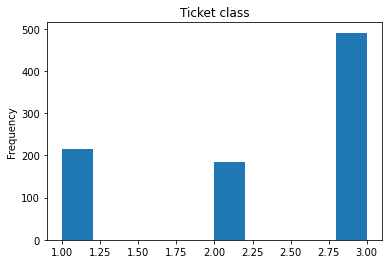

In [ ]:
train['Pclass'].plot(kind = 'hist', title = "Ticket class") # todo means

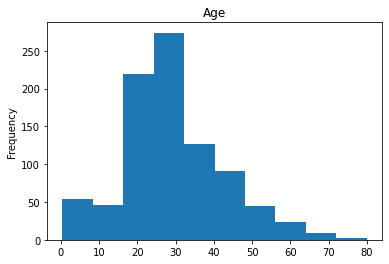

In [ ]:
train['Age'].plot(kind = 'hist', title = "Age")

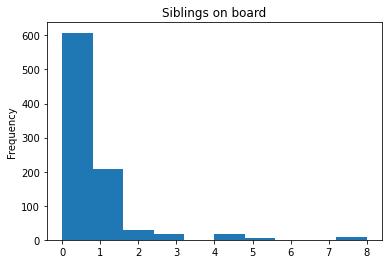

In [ ]:
train['SibSp'].plot(kind = 'hist', title = "Siblings on board")

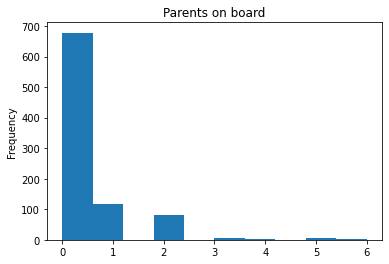

In [ ]:
train['Parch'].plot(kind = 'hist', title = "Parents on board")

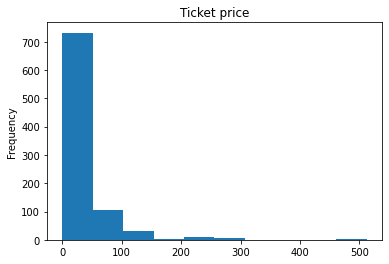

In [ ]:
train['Fare'].plot(kind = 'hist', title = "Ticket price")

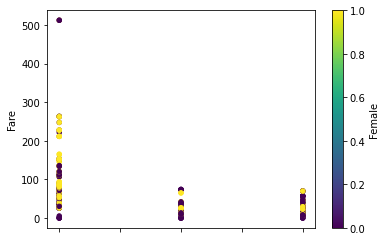

In [ ]:
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
train.plot.scatter(x='Pclass', y='Fare', c='Female', colormap='viridis')

### 1.1.2 Bezug auf Überlebenschange

https://www.kaggle.com/code/zlatankr/titanic-random-forest-82-78

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


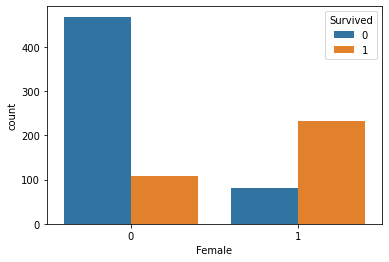

In [ ]:
sns.countplot(train['Female'], hue=train['Survived'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


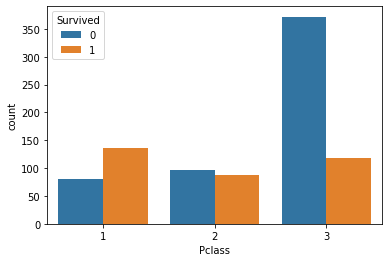

In [ ]:
sns.countplot(train['Pclass'], hue=train['Survived'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


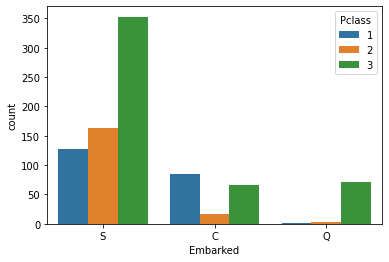

In [ ]:
sns.countplot(train_raw['Embarked'], hue=train_raw['Pclass'])

Was sagt der Name aus? 

Je langer der Name desto höher die Überlebenschange

In [ ]:
train_raw['Name_Len'] = train_raw['Name'].apply(lambda x: len(x))
train_raw['Survived'].groupby(pd.qcut(train_raw['Name_Len'],5)).mean()

Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

Alter: je jünger desto besser

In [ ]:
train['Survived'].groupby(pd.qcut(train['Age'],10)).mean()

Age
(0.419, 16.0]     0.550000
(16.0, 20.0]      0.341772
(20.0, 22.0]      0.436170
(22.0, 26.0]      0.363636
(26.0, 26.508]    0.095745
(26.508, 30.0]    0.413043
(30.0, 34.0]      0.410256
(34.0, 40.0]      0.505263
(40.0, 47.0]      0.280488
(47.0, 80.0]      0.415730
Name: Survived, dtype: float64

In [ ]:
train['Survived'].groupby(pd.qcut(train['Fare'], 10)).mean()

Fare
(-0.001, 7.55]       0.141304
(7.55, 7.854]        0.298851
(7.854, 8.05]        0.179245
(8.05, 10.5]         0.230769
(10.5, 14.454]       0.428571
(14.454, 21.679]     0.420455
(21.679, 27.0]       0.516854
(27.0, 39.688]       0.373626
(39.688, 77.958]     0.528090
(77.958, 512.329]    0.758621
Name: Survived, dtype: float64

In [ ]:
train['Survived'].groupby(train['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [ ]:
train['Survived'].groupby(train['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [ ]:
train['Survived'].groupby(train['Cabin letter']).mean()

Cabin letter
A      0.466667
B      0.744681
C      0.593220
D      0.757576
E      0.750000
F      0.615385
G      0.500000
NaN    0.299854
T      0.000000
Name: Survived, dtype: float64

In [ ]:
train['Survived'].groupby(pd.qcut(train['Cabin number'], 8)).mean()

Cabin number
(1.999, 10.0]      0.703704
(10.0, 22.0]       0.750000
(22.0, 32.125]     0.565217
(32.125, 40.5]     0.791667
(40.5, 52.0]       0.680000
(52.0, 78.0]       0.653846
(78.0, 97.875]     0.590909
(97.875, 148.0]    0.680000
Name: Survived, dtype: float64

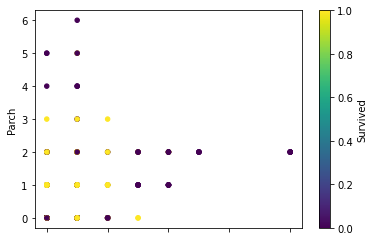

In [ ]:
#columns_to_plt = train['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Female', 'Numbert of Cabins', 'Cabin letter', 'Cabin number']
train.plot.scatter(x='SibSp', y='Parch', c='Survived', colormap='viridis')

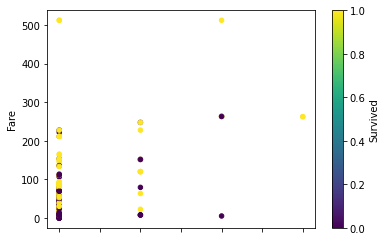

In [ ]:
train.plot.scatter(x='Numbert of Cabins', y='Fare', c='Survived', colormap='viridis')

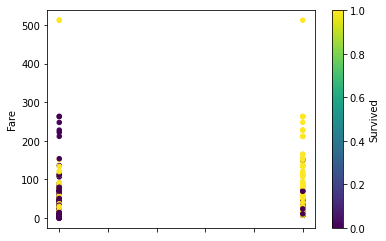

In [ ]:
train.plot.scatter(x='Female', y='Fare', c='Survived', colormap='viridis')

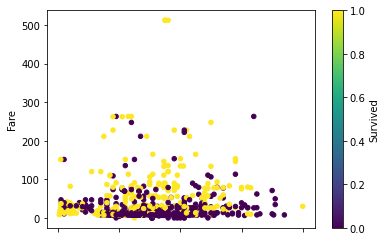

In [ ]:
train.plot.scatter(x='Age', y='Fare', c='Survived', colormap='viridis')

In [ ]:
filtered_train = train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Cherbourg', 'Queenstown', 'Southhampton', 
                        'Cabin letter', 'Cabin number', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'NaN', 'T'], axis=1)
filtered_train.to_csv(path + 'data_filtered.csv', index = False)

filtered_test = test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Cherbourg', 'Queenstown', 'Southhampton', 
                        'Cabin letter', 'Cabin number', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'NaN'], axis=1)
filtered_test.to_csv(path +'data_test_filtered.csv', index = False)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Age                891 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Ticket             891 non-null    object 
 8   Fare               891 non-null    float64
 9   Embarked           889 non-null    object 
 10  Name len           891 non-null    int64  
 11  Female             891 non-null    uint8  
 12  Age known Flag     891 non-null    int64  
 13  Fam_Size           891 non-null    int64  
 14  Cherbourg          891 non-null    uint8  
 15  Queenstown         891 non-null    uint8  
 16  Southhampton       891 non